In [97]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
from tools.utils import relative2absolute
%matplotlib inline

In [98]:
extensions = set()
sizes = []
tags = []
for image_path in Path('../../data/raw/images/').glob('*'):
    extensions.add(image_path.suffix)
    im = Image.open(image_path)
    width, height = im.size
    sizes.append([image_path.name, width, height, width/height])
    
    annotations = Path('../../data/raw/annotations/', f'{image_path.stem}.txt')
    if annotations.exists():
        with open(annotations) as readable:
            for idx, line in enumerate(readable):
                parts = line.split(' ')
                data = [image_path.name, idx, int(parts[0])]
                data.extend([float(part) for part in parts[1:]])
                tags.append(data)
                

image_frame = pd.DataFrame(sizes, columns =['file_name','width', 'height', 'ratio']).set_index('file_name')
tags_frame = pd.DataFrame(tags, 
                          columns =['file_name', 'idx', 
                                    'class', 'x', 'y', 'width', 'height']).set_index(['file_name', 'idx'])

In [99]:
image_frame.head()

,width,height,ratio
file_name,,,
22048133_1686836831391287_6387848401645317210_o.png,1015,677,1.499261
996895_493572574051058_316153375_n.jpg,736,736,1.000000
61640541_142631743486691_7943349021697799137_n.jpg,640,640,1.000000
11001587_786347394773573_624563927147151927_o.jpg,2048,1365,1.500366
966826_469260216482294_373092455_o.jpg,1673,1683,0.994058


In [100]:
tags_frame.head()

,,class,x,y,width,height
file_name,idx,,,,,
996895_493572574051058_316153375_n.jpg,0,0,0.493886,0.500679,0.322011,0.906250
61946167_384134885642532_462007131315538527_n.jpg,0,2,0.351562,0.699219,0.381250,0.601562
60703320_161121914922375_4903454286030055967_n.jpg,0,0,0.866406,0.345313,0.267188,0.665625
13312774_1055286684546308_7098649280370769145_n.png,0,0,0.489412,0.492353,0.216471,0.629412
1237160_510592712349044_1570041022_n.png,0,2,0.274510,0.757576,0.203209,0.484848


In [101]:
with open('../../data/raw/annotations/classes.txt') as readable:
    print(readable.read())

valentina
tamazula
valentina-negra
botanera
valentina-polvo



In [102]:
tags_frame['class'].value_counts()

0    290
2    102
3     33
4     26
1     17
Name: class, dtype: int64

## 

In [103]:
def to_coordinates(cx, cy, w, h, img_w, img_h):
    pcx = (cx - w/2) * img_w
    pcy = (cy - h/2) * img_h
    width = w * img_w
    height = h * img_h
    return pcx, pcy, width, height

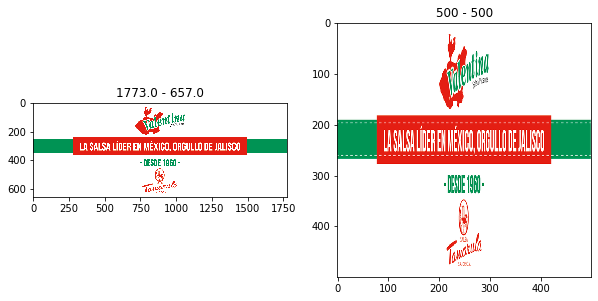

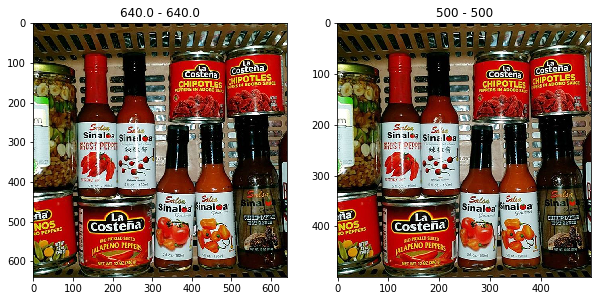

0


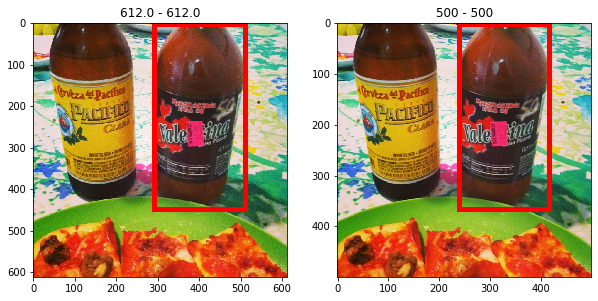

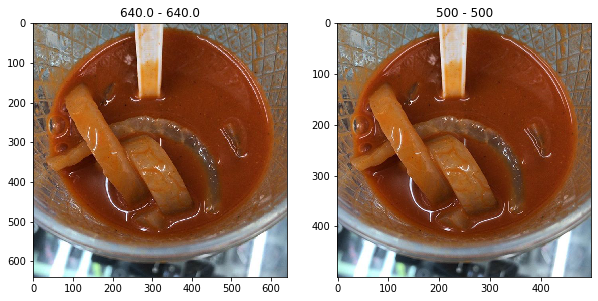

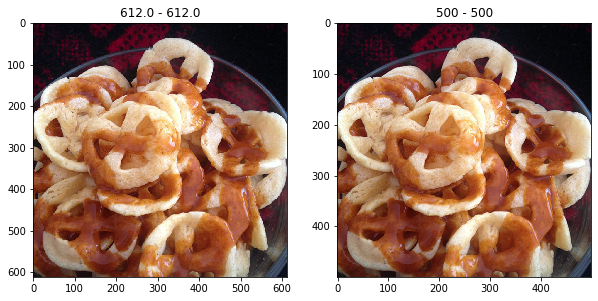

0


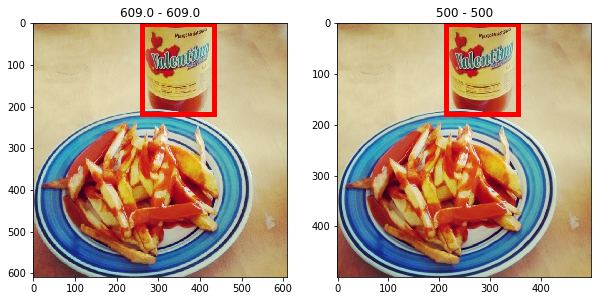

0
1


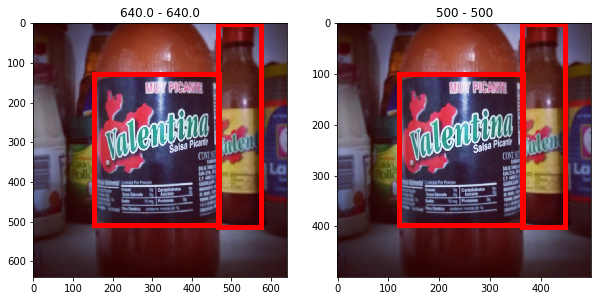

0


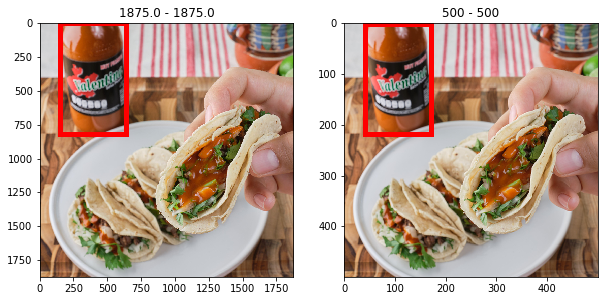

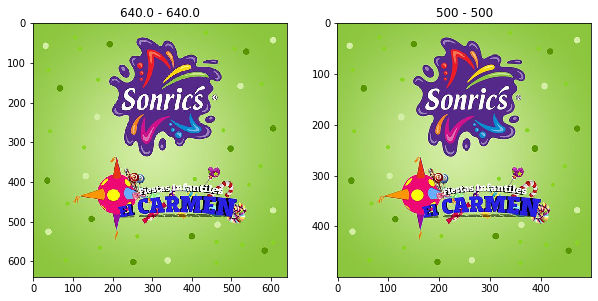

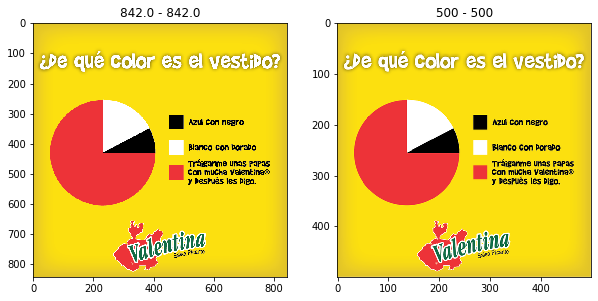

In [105]:
to_resize_sample = image_frame.sample(10, random_state=40)
new_size = (500,500)

for image, data in to_resize_sample.iterrows():
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    
    image_path = Path('../../data/raw/images', image)
    im = Image.open(image_path)
    resized_im = im.resize(new_size, Image.ANTIALIAS)
    
    ax1.imshow(im)
    ax1.set_title(f'{data["width"]} - {data["height"]}')
                  
    ax2.imshow(resized_im)
    ax2.set_title(f'{new_size[0]} - {new_size[1]}')

    try:
        for idx, tag_data in tags_frame.loc[image].iterrows():
            print(idx)
            x_rect, y_rect, width_rect, height_rect = relative2absolute(tag_data['x'], tag_data['y'],
                                                                     tag_data['width'], tag_data['height'], 
                                                                     data["width"], data["height"])
            rect = patches.Rectangle((x_rect,y_rect),width_rect,height_rect,linewidth=5,edgecolor='r',facecolor='none')
            ax1.add_patch(rect)
                  
            x_rect, y_rect, width_rect, height_rect = relative2absolute(tag_data['x'], tag_data['y'],
                                                                     tag_data['width'], tag_data['height'], 
                                                                     new_size[0], new_size[1])
            rect = patches.Rectangle((x_rect,y_rect),width_rect,height_rect,linewidth=5,edgecolor='r',facecolor='none')
            ax2.add_patch(rect)
    except KeyError:
        pass
    plt.show()

## Bulk resizing

In [96]:
new_size = (500,500)
new_image_folder = Path('../../data/raw/resized')
new_image_folder.mkdir(exist_ok=True)

for image, data in image_frame.iterrows():
    
    image_path = Path('../../data/raw/images', image)
    new_image_path = Path(new_image_folder, f'{image_path.stem}.jpg')
    if not new_image_path.exists():
        im = Image.open(image_path)
        if im.mode == 'RGBA':
            im = im.convert("RGB")
        resized_im = im.resize(new_size, Image.ANTIALIAS)

        resized_im.save(new_image_path, "JPEG", optimize=True)